# 1. Processing Machine events and task events data for data preparation

# Retrieving Task Runtimes

To retrieve task runtime:
    1. Idenitfy submissions and completetions of each job, removing duplicate entries
    2. Calculate the duration between the submission and completion timestamps to determine how long each job ran

Note:
For each job id, the runtime is the timestamp of event type = 4 (finished) - event type = 0 (submitted)
Also, since timestamp is in millisecond, get the runtime in seconds (round off)
Laslt, only store tasks with both finished and submitted ids with their actual runtimes.

In [13]:
from DataPrep.task_runtime_calculator import calculate_task_runtimes

task_runtimes, maximumStamp = calculate_task_runtimes()

# Drop rows with missing data (if any)
task_runtimes = task_runtimes.dropna(subset=['task_index', 'CPU_request', 'memory_request', 'timestamp', 'runtime'])

# Print results
print(f"Maximum timestamp: {maximumStamp}")
print(f"Found {len(task_runtimes)} tasks with complete runtime data")
print("\nSample of task runtimes:")
print(task_runtimes.head())

Maximum timestamp: 5611.0
Found 38362 tasks with complete runtime data

Sample of task runtimes:
       job_ID  task_index  CPU_request  memory_request  timestamp  runtime
0  6250345153         878      0.06873        0.011930      604.0   2368.0
1  6251639646           0      0.06250        0.015900      604.0     71.0
2  6251668759           0      0.06250        0.004662      612.0     50.0
3  6250345153         822      0.06873        0.011930      614.0   2155.0
4  6251668917           0      0.03125        0.015900      617.0     36.0


# Retrieving Available Instance Types and Their Prices

In [14]:
from DataPrep.instance_retriever import get_instance_types_and_prices

instance_types = get_instance_types_and_prices()
sorted_instance_types = instance_types.sort_values(
    by=["capacity_CPU", "capacity_memory"], ascending=[False, False]
)
instance_types = sorted_instance_types
print("Available Instance Types and Their Normalized Prices:")
print("=" * 60)
print(instance_types)

Available Instance Types and Their Normalized Prices:
    capacity_CPU  capacity_memory  normalized_price
10          1.00          1.00000          1.000000
9           1.00          0.50000          0.940904
8           0.50          0.96780          0.555290
7           0.50          0.74900          0.529430
6           0.50          0.49950          0.499941
5           0.50          0.24930          0.470369
4           0.50          0.12410          0.455571
3           0.50          0.06158          0.448182
2           0.50          0.03085          0.444550
1           0.25          0.24980          0.249976


# Stratus Implementation

### Try simulating Stratus

In [21]:
from schedulers.stratus_scheduler import StratusScheduler

scheduler = StratusScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')

total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:

    if timestamp >= 700:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.packer(tasks)

    # Accumulate CPU and memory utilization
    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))
print("Price of simulation: " + str(scheduler.price_counter))
print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")

Number of instances used: 4
Price of simulation: 6039.764862
Average CPU utilization: 30.98%
Average memory utilization: 33.13%


## First Fit Implementation

### Try First Fit

In [ ]:
from schedulers.first_fit_scheduler import FirstFitScheduler

scheduler = FirstFitScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')


total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:
    if timestamp >= 700:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.first_fit_scheduler(tasks)
    
    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))
print("Price of simulation: " + str(scheduler.price_counter))
print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")

Number of instances used: 1
Price of simulation: 4585.0
Average CPU utilization: 32.62%
Average memory utilization: 12.92%


## Best Fit Implementation

### Trying Best Fit

In [26]:
from schedulers.best_fit_scheduler import BestFitScheduler

scheduler = BestFitScheduler(instance_types)
tasks_by_timestamp = task_runtimes.groupby('timestamp')

total_cpu_utilization = 0
total_memory_utilization = 0
timestamp_count = 0

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:

    if timestamp >= 700:
        break
    
    # Free expired tasks and instances
    scheduler.free_tasks_and_instances(timestamp)
    
    # Pass tasks for the current timestamp to the packer
    scheduler.best_fit_scheduler(tasks)

    total_cpu_utilization += scheduler.cpu_utilization
    total_memory_utilization += scheduler.memory_utilization
    timestamp_count += 1

# Calculate average CPU and memory utilization
average_cpu_utilization = total_cpu_utilization / timestamp_count if timestamp_count > 0 else 0
average_memory_utilization = total_memory_utilization / timestamp_count if timestamp_count > 0 else 0

# Check results
print("Number of instances used: " + str(scheduler.instance_counter))
print("Price of simulation: " + str(scheduler.price_counter))
print("Average CPU utilization: " + str(round(average_cpu_utilization, 2)) + "%")
print("Average memory utilization: " + str(round(average_memory_utilization, 2)) + "%")

Number of instances used: 1
Price of simulation: 4585.0
Average CPU utilization: 32.62%
Average memory utilization: 12.92%


## Comparing all 3 incremently based on timestamp

In [27]:
stratus_scheduler = StratusScheduler(instance_types)
firstfit_scheduler = FirstFitScheduler(instance_types)
bestfit_scheduler = BestFitScheduler(instance_types)


timestamp_points = []

# Stratus data
stratus_cpu_utilization = []
stratus_memory_utilization = []
stratus_price = []
stratus_instances = []

# FirstFit data
firstfit_cpu_utilization = []
firstfit_memory_utilization = []
firstfit_price = []
firstfit_instances = []

# BestFit data
bestfit_cpu_utilization = []
bestfit_memory_utilization = []
bestfit_price = []
bestfit_instances = []

tasks_by_timestamp = task_runtimes.groupby('timestamp')

# Iterate over each timestamp and its corresponding tasks
for timestamp, tasks in tasks_by_timestamp:
    
    timestamp_points.append(timestamp)

    # Free expired tasks and instances
    stratus_scheduler.free_tasks_and_instances(timestamp)
    firstfit_scheduler.free_tasks_and_instances(timestamp)
    bestfit_scheduler.free_tasks_and_instances(timestamp)

    # Pass tasks for the current timestamp to the packer
    stratus_scheduler.packer(tasks)
    firstfit_scheduler.first_fit_scheduler(tasks)
    bestfit_scheduler.best_fit_scheduler(tasks)

    # Add new data
    stratus_cpu_utilization.append(stratus_scheduler.cpu_utilization)
    stratus_memory_utilization.append(stratus_scheduler.memory_utilization)
    stratus_price.append(stratus_scheduler.price_counter)
    stratus_instances.append(stratus_scheduler.instance_counter)

    firstfit_cpu_utilization.append(firstfit_scheduler.cpu_utilization)
    firstfit_memory_utilization.append(firstfit_scheduler.memory_utilization)
    firstfit_price.append(firstfit_scheduler.price_counter)
    firstfit_instances.append(firstfit_scheduler.instance_counter)

    bestfit_cpu_utilization.append(bestfit_scheduler.cpu_utilization)
    bestfit_memory_utilization.append(bestfit_scheduler.memory_utilization)
    bestfit_price.append(bestfit_scheduler.price_counter)
    bestfit_instances.append(bestfit_scheduler.instance_counter)


## Visualisation of performance

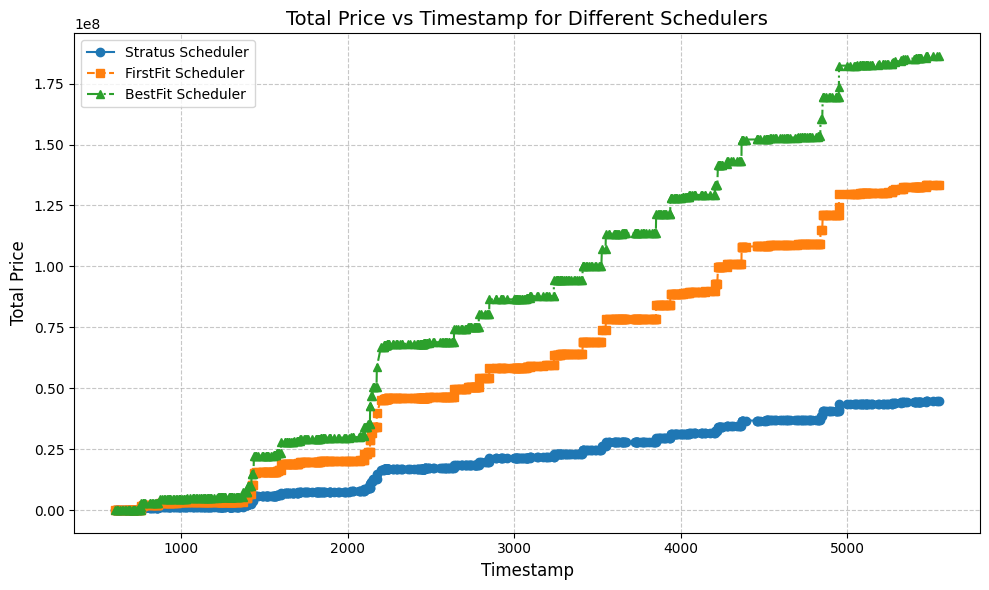

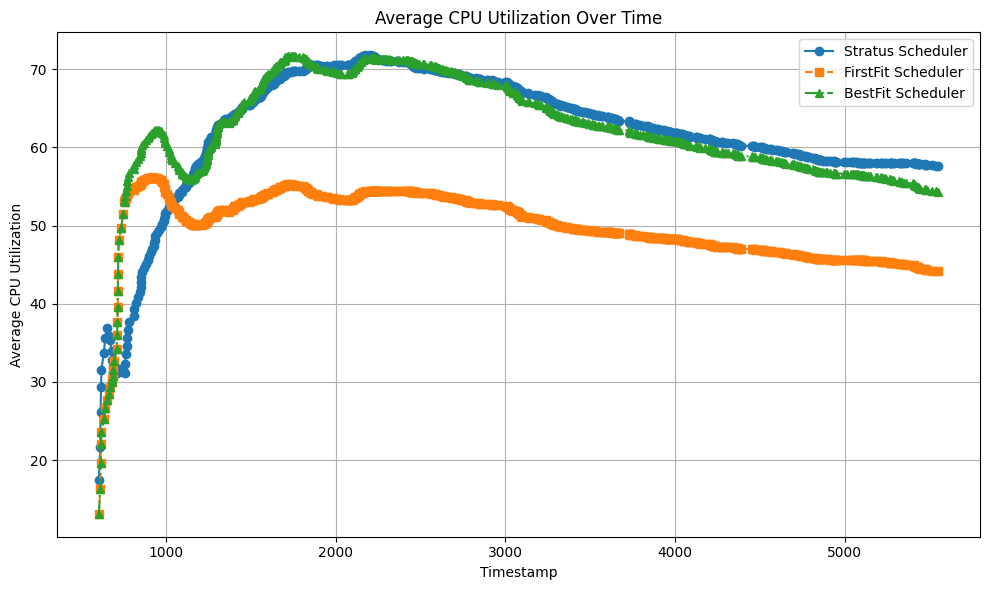

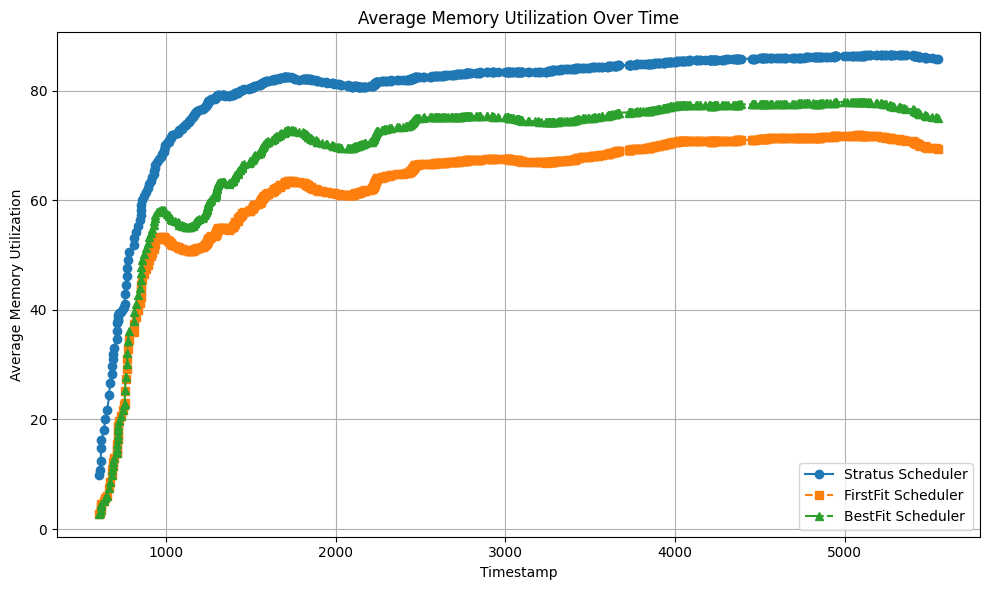

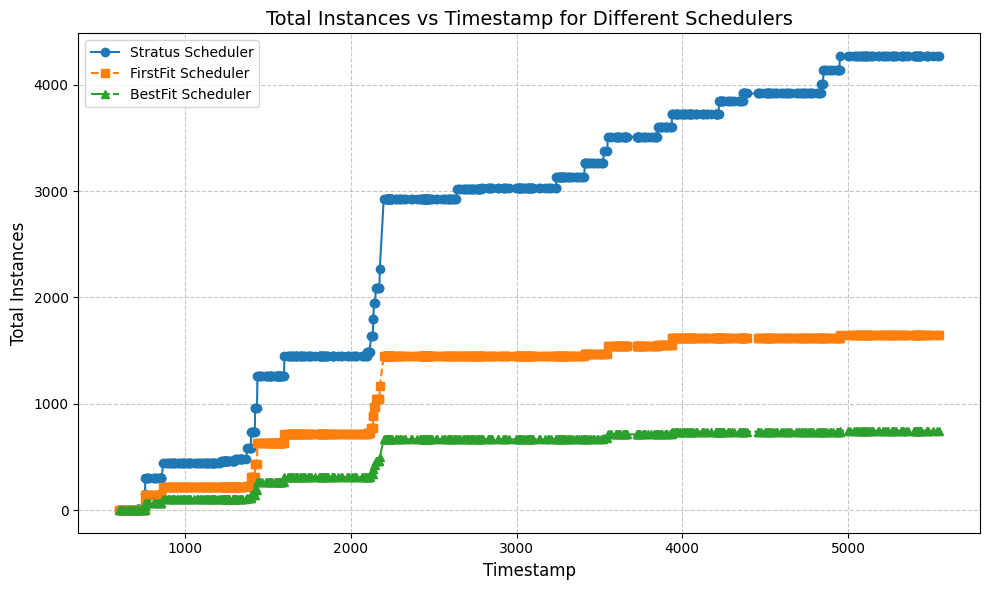

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total price for each scheduler against the timestamp
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_price, label='Stratus Scheduler', linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_price, label='FirstFit Scheduler', linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_price, label='BestFit Scheduler', linestyle='-.', marker='^')
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Total Price', fontsize=12)
plt.title('Total Price vs Timestamp for Different Schedulers', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate cumulative average utilization for each scheduler
stratus_avg_cpu_utilization = np.cumsum(stratus_cpu_utilization) / np.arange(1, len(stratus_cpu_utilization) + 1)
firstfit_avg_cpu_utilization = np.cumsum(firstfit_cpu_utilization) / np.arange(1, len(firstfit_cpu_utilization) + 1)
bestfit_avg_cpu_utilization = np.cumsum(bestfit_cpu_utilization) / np.arange(1, len(bestfit_cpu_utilization) + 1)
# Plot CPU utilization against timestamp for the three schedulers
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_avg_cpu_utilization, label="Stratus Scheduler", linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_avg_cpu_utilization, label="FirstFit Scheduler", linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_avg_cpu_utilization, label="BestFit Scheduler", linestyle='-.', marker='^')
plt.title("Average CPU Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Average CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate cumulative average utilization for each scheduler
stratus_avg_mem_utilization = np.cumsum(stratus_memory_utilization) / np.arange(1, len(stratus_memory_utilization) + 1)
firstfit_avg_mem_utilization = np.cumsum(firstfit_memory_utilization) / np.arange(1, len(firstfit_memory_utilization) + 1)
bestfit_avg_mem_utilization = np.cumsum(bestfit_memory_utilization) / np.arange(1, len(bestfit_memory_utilization) + 1)
# Plot CPU utilization against timestamp for the three schedulers
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_avg_mem_utilization, label="Stratus Scheduler", linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_avg_mem_utilization, label="FirstFit Scheduler", linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_avg_mem_utilization, label="BestFit Scheduler", linestyle='-.', marker='^')
plt.title("Average Memory Utilization Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Average Memory Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the total instances for each scheduler against the timestamp
plt.figure(figsize=(10, 6))
plt.plot(timestamp_points, stratus_instances, label='Stratus Scheduler', linestyle='-', marker='o')
plt.plot(timestamp_points, firstfit_instances, label='FirstFit Scheduler', linestyle='--', marker='s')
plt.plot(timestamp_points, bestfit_instances, label='BestFit Scheduler', linestyle='-.', marker='^')
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Total Instances', fontsize=12)
plt.title('Total Instances vs Timestamp for Different Schedulers', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
